## Provena Toy Example

This relies on some pre-registered components and is intended to show an example provenance enabled workflow by integrating with the provena APIs. 

The actual computation/validation has been stripped from the source notebook - but hopefully it will be clear where this can be reintroduced

### Provena workflow configuration setup

In [1]:
# This is a small helper class which provides a config object for validation and
# a loader function
import example_workflow_config

# This is a helper function for managing authentication with Provena
from provenaclient import ProvenaClient, Config
from provenaclient.auth import DeviceFlow
from provenaclient.auth.implementations import OfflineFlow

import json
import time
from pprint import pprint

In [2]:
import os
from dotenv import load_dotenv


# Provena config - replace with your Provena instance endpoints
client_config = Config(
    domain="dev.rrap-is.com",
    realm_name="rrap"
)


offline_mode = False

if offline_mode:
    load_dotenv()
    offline_token=os.getenv('PROVENA_API_TOKEN')
    assert offline_token, "Offline token must be present in .env file e.g. PROVENA_API_TOKEN=1234."
    print(f"Offline mode activated and token found in .env file.")

if not offline_mode:
    auth = DeviceFlow(config=client_config,
                    client_id="client-tools")
else:
    auth = OfflineFlow(config=client_config, client_id="automated-access", offline_token=offline_token)


# Instantiate the client.
client = ProvenaClient(config=client_config, auth=auth)

In [3]:
# Start by loading the config from the specified path 

# You will need to register: person, organisation, dataset template and model run workflow template and update the config

# NOTE this could change from run to run - this holds all information required to run this model. 
config_path = "configs/example_workflow3.json"
config = example_workflow_config.load_config(path=config_path)
config.pprint()


{
  "inputs": {
    "input_dataset": "10378.1/1904964",
    "input_dataset_template": "10378.1/1905250"
  },
  "outputs": {
    "output_dataset": "10378.1/1904961",
    "output_dataset_template": "10378.1/1926245"
  },
  "associations": {
    "person": "10378.1/1893843",
    "organisation": "10378.1/1893860"
  },
  "workflow_configuration": {
    "workflow_template": "10378.1/1905251"
  }
}


In [4]:
# let's validate the workflow config - this fetches ALL items referenced in the
# workflow json to ensure the items are valid 


valid = await config.validate_entities(client)

if not valid:
    print("FAILED VALIDATION")
    raise Exception("Workflow config validation exception occurred. See output above.")


Validating registered Provena entities in config
status=Status(success=True, details="Successfully fetched data for handle '10378.1/1904964'") item=ItemDataset(display_name='Parth testing', user_metadata=None, collection_format=CollectionFormat(associations=CollectionFormatAssociations(organisation_id='10378.1/1893860', data_custodian_id='10378.1/1893843', point_of_contact=None), approvals=CollectionFormatApprovals(ethics_registration=DatasetEthicsRegistrationCheck(relevant=False, obtained=False), ethics_access=DatasetEthicsAccessCheck(relevant=False, obtained=False), indigenous_knowledge=IndigenousKnowledgeCheck(relevant=False, obtained=False), export_controls=ExportControls(relevant=False, obtained=False)), dataset_info=CollectionFormatDatasetInfo(name='Parth testing', description='testing dataset', access_info=AccessInfo(reposited=True, uri=None, description=None), publisher_id='10378.1/1893860', created_date=CreatedDate(relevant=True, value=datetime.date(2024, 6, 6)), published_dat

## Model run integration
Now that the validation of the workflow configuration (incl. registered entities) is complete - we can move into the example of running the model against this configuration.

In [31]:
# let's establish the paths of the input from the dataset
def pprint_json(content) -> None:
    print(json.dumps(content,indent=2))

# fetch the dataset 
ds_id = config.inputs.input_dataset
fetched_ds = await client.datastore.fetch_dataset(id=ds_id)

print("Dataset Display Name is:", fetched_ds.item.display_name, "and Dataset ID is:", fetched_ds.item.id)
print(fetched_ds.json(indent=2))

Dataset Display Name is: Parth testing and Dataset ID is: 10378.1/1904964
{
  "status": {
    "success": true,
    "details": "Successfully fetched data for handle '10378.1/1904964'"
  },
  "item": {
    "display_name": "Parth testing",
    "user_metadata": null,
    "collection_format": {
      "associations": {
        "organisation_id": "10378.1/1893860",
        "data_custodian_id": "10378.1/1893843",
        "point_of_contact": null
      },
      "approvals": {
        "ethics_registration": {
          "relevant": false,
          "obtained": false
        },
        "ethics_access": {
          "relevant": false,
          "obtained": false
        },
        "indigenous_knowledge": {
          "relevant": false,
          "obtained": false
        },
        "export_controls": {
          "relevant": false,
          "obtained": false
        }
      },
      "dataset_info": {
        "name": "Parth testing",
        "description": "testing dataset",
        "access_info": {
 

In [6]:
# determine the external reposit path
file_path = fetched_ds.item.collection_format.dataset_info.access_info.uri
print(file_path)

None


As demonstrated above, it is possible to retrieve the associated file path from the registered Dataset (assuming this info was included at registration time). Or the existing file path mechanism could continue being used.

A similar approach works for the other inputs. Shown below.

In [7]:
async def fetch_and_path(id: str):
    dataset = await client.datastore.fetch_dataset(id=id)
    path = dataset.item.collection_format.dataset_info.access_info.uri
    return dataset, path

# Dataset and Dataset file path.
dataset, dataset_file_path_path = await fetch_and_path(id=config.inputs.input_dataset)

pprint_json({
   "Dataset File Path: " : dataset_file_path_path
})

{
  "Dataset File Path: ": null
}


Alternatively, if we wanted to use the data storage utilities of the Provena data store, we could register a reposited dataset, and use the dynamic credential generation to produce r or r/w credentials into that specific dataset.

### Running our fake model

We are going to pretend to produce some output from this process.

In [8]:
def fake_data_fetch(path: str) -> int:
    # This method would take the path and return the data
    return 0

fake_temperature = fake_data_fetch(dataset_file_path_path)


def fake_model(temperature: int) -> int:
    # this model does some heavy lifting and takes 5 seconds to finish 
    time.sleep(5) 
    
    return 0

# let's run our model with the inputs 

# start timer
start_time = int(time.time())

# run the model 
fake_model_output = fake_model(
    temperature=fake_temperature    
)

end_time = int(time.time())

print(f"Ran fake hourly JYI calculation, took {end_time - start_time} seconds.")



Ran fake hourly JYI calculation, took 5 seconds.


Now we have ran the toy model, let's register a provenance record which records the model run, the inputs used, and the outputs produced.

We need to think more about the output. 

There are two primary ways that Provena supports registering the results of a model run. 

1. Dynamically register a new Dataset and link to this dataset. This is the _preferred_ method as it creates a clear causal chain between the model and the output dataset.
2. Use a deferred or defined resource in an output dataset template to register the outputs into an existing dataset. E.g. overwrite an existing file or contribute new files to an existing dataset. This method produces less structurally clear provenance chains and may obfuscate the history of data (if overwriting).

We will show both methods. 

Model runs satisfy the following JSON schema

```json
{
  "workflow_template_id": "string",
  "inputs": [
    {
      "dataset_template_id": "string",
      "dataset_id": "string",
      "dataset_type": "DATA_STORE",
      "resources": {
        "additionalProp1": "string",
        "additionalProp2": "string",
        "additionalProp3": "string"
      }
    }
  ],
  "outputs": [
    {
      "dataset_template_id": "string",
      "dataset_id": "string",
      "dataset_type": "DATA_STORE",
      "resources": {
        "additionalProp1": "string",
        "additionalProp2": "string",
        "additionalProp3": "string"
      }
    }
  ],
  "annotations": {
    "additionalProp1": "string",
    "additionalProp2": "string",
    "additionalProp3": "string"
  },
  "description": "string",
  "associations": {
    "modeller_id": "string",
    "requesting_organisation_id": "string"
  },
  "start_time": 0,
  "end_time": 0
}
```

#### Overwrite an existing output at a specified path

Let's start with method 2) and overwrite a specified output. This dataset is pre-registered and is included in our config.

In [32]:
### Overwrite existing output

output_dataset_id = config.outputs.output_dataset

# we can resolve the path using the same approach as above, or using existing
# NBIC path structure

output_ds, output_path = await fetch_and_path(id=output_dataset_id)

print(output_ds.item.json(indent=2))

{
  "display_name": "Parth testing",
  "user_metadata": null,
  "collection_format": {
    "associations": {
      "organisation_id": "10378.1/1893860",
      "data_custodian_id": "10378.1/1893843",
      "point_of_contact": null
    },
    "approvals": {
      "ethics_registration": {
        "relevant": false,
        "obtained": false
      },
      "ethics_access": {
        "relevant": false,
        "obtained": false
      },
      "indigenous_knowledge": {
        "relevant": false,
        "obtained": false
      },
      "export_controls": {
        "relevant": false,
        "obtained": false
      }
    },
    "dataset_info": {
      "name": "Parth testing",
      "description": "testing dataset",
      "access_info": {
        "reposited": true,
        "uri": null,
        "description": null
      },
      "publisher_id": "10378.1/1893860",
      "created_date": {
        "relevant": true,
        "value": "2024-06-06"
      },
      "published_date": {
        "relevant"

In [10]:
from ProvenaInterfaces.ProvenanceAPI import ModelRunRecord, TemplatedDataset, DatasetType, AssociationInfo
from ProvenaInterfaces.AsyncJobAPI import JobStatus

# Building the Model Run Payload.
model_run_payload = ModelRunRecord(
    workflow_template_id=config.workflow_configuration.workflow_template,
    model_version = None, 
    inputs = [
        TemplatedDataset(
            dataset_template_id=config.inputs.input_dataset_template, 
            dataset_id=config.inputs.input_dataset,
            dataset_type=DatasetType.DATA_STORE
        )
    ], 
    outputs=[
        TemplatedDataset(
            dataset_template_id=config.outputs.output_dataset_template, 
            dataset_id=config.outputs.output_dataset,
            dataset_type=DatasetType.DATA_STORE
        )
    ], 
    annotations=None,
    display_name="Notebook Model Run Testing",
    description="Standard Provena Model Run Example",
    study_id=None,
    associations=AssociationInfo(
        modeller_id=config.associations.person,
        requesting_organisation_id=config.associations.organisation
    ),
    start_time=start_time,
    end_time=end_time

)


In [11]:
# Registering the model run 
model_run_register_result = await client.prov_api.register_model_run(model_run_payload=model_run_payload)


In [12]:
# Check the response of the model run registration
print("Status of registration", model_run_register_result.status)
print("Job Session ID", model_run_register_result.session_id)

Status of registration success=True details='Job dispatched, monitor session ID using the job API to see progress.'
Job Session ID 4a2e188b-3803-404c-a249-b2a5db01e103


In [13]:

# Check the job to see if it's complete. We will do this by polling the job_api
job_result = await client.job_api.await_successful_job_completion(session_id=model_run_register_result.session_id)

while job_result.status != JobStatus.SUCCEEDED: # Keep polling on this cell till this turns to "SUCCEEDED"
    
    job_result = await client.job_api.await_successful_job_completion(session_id=model_run_register_result.session_id)
    pprint(job_result.result)
    pprint(job_result.job_type)


print()
print("Current job status:", job_result.status) 


Starting wait_for_entry_in_queue polling stage.
Polling Job API. Wait time: 0sec out of 20sec.
Running wait_for_entry_in_queue callback. Session ID: 4a2e188b-3803-404c-a249-b2a5db01e103.
200OK response for user fetch of 4a2e188b-3803-404c-a249-b2a5db01e103.
Finished wait_for_entry_in_queue polling stage.
Starting wait_for_in_progress polling stage.
Polling Job API. Wait time: 0sec out of 120sec.
Running wait for in progress callback. Session ID: 4a2e188b-3803-404c-a249-b2a5db01e103.
200OK response for user fetch of 4a2e188b-3803-404c-a249-b2a5db01e103 in state PENDING.
Callback registered incomplete. Waiting for polling interval.
Polling Job API. Wait time: 2sec out of 120sec.
Running wait for in progress callback. Session ID: 4a2e188b-3803-404c-a249-b2a5db01e103.
200OK response for user fetch of 4a2e188b-3803-404c-a249-b2a5db01e103 in state PENDING.
Callback registered incomplete. Waiting for polling interval.
Polling Job API. Wait time: 4sec out of 120sec.
Running wait for in progres

In [14]:

method_two_record_info = job_result.result["record"]
pprint_json(method_two_record_info)

{
  "prov_json": "{\"prefix\": {\"default\": \"http://hdl.handle.net/\"}, \"activity\": {\"10378.1/1948390\": {\"model_run/10378.1/1948390\": true, \"item_category\": \"ACTIVITY\", \"item_subtype\": \"MODEL_RUN\"}}, \"entity\": {\"10378.1/1904964\": {\"model_run/10378.1/1948390\": true, \"item_category\": \"ENTITY\", \"item_subtype\": \"DATASET\"}, \"10378.1/1904961\": {\"model_run/10378.1/1948390\": true, \"item_category\": \"ENTITY\", \"item_subtype\": \"DATASET\"}, \"10378.1/1905251\": {\"model_run/10378.1/1948390\": true, \"item_category\": \"ENTITY\", \"item_subtype\": \"MODEL_RUN_WORKFLOW_TEMPLATE\", \"prov:type\": {\"$\": \"prov:Collection\", \"type\": \"prov:QUALIFIED_NAME\"}}, \"10378.1/1905250\": {\"model_run/10378.1/1948390\": true, \"item_category\": \"ENTITY\", \"item_subtype\": \"DATASET_TEMPLATE\"}, \"10378.1/1926245\": {\"model_run/10378.1/1948390\": true, \"item_category\": \"ENTITY\", \"item_subtype\": \"DATASET_TEMPLATE\"}, \"10378.1/1924630\": {\"model_run/10378.1/1

Quick and dirty visualisation

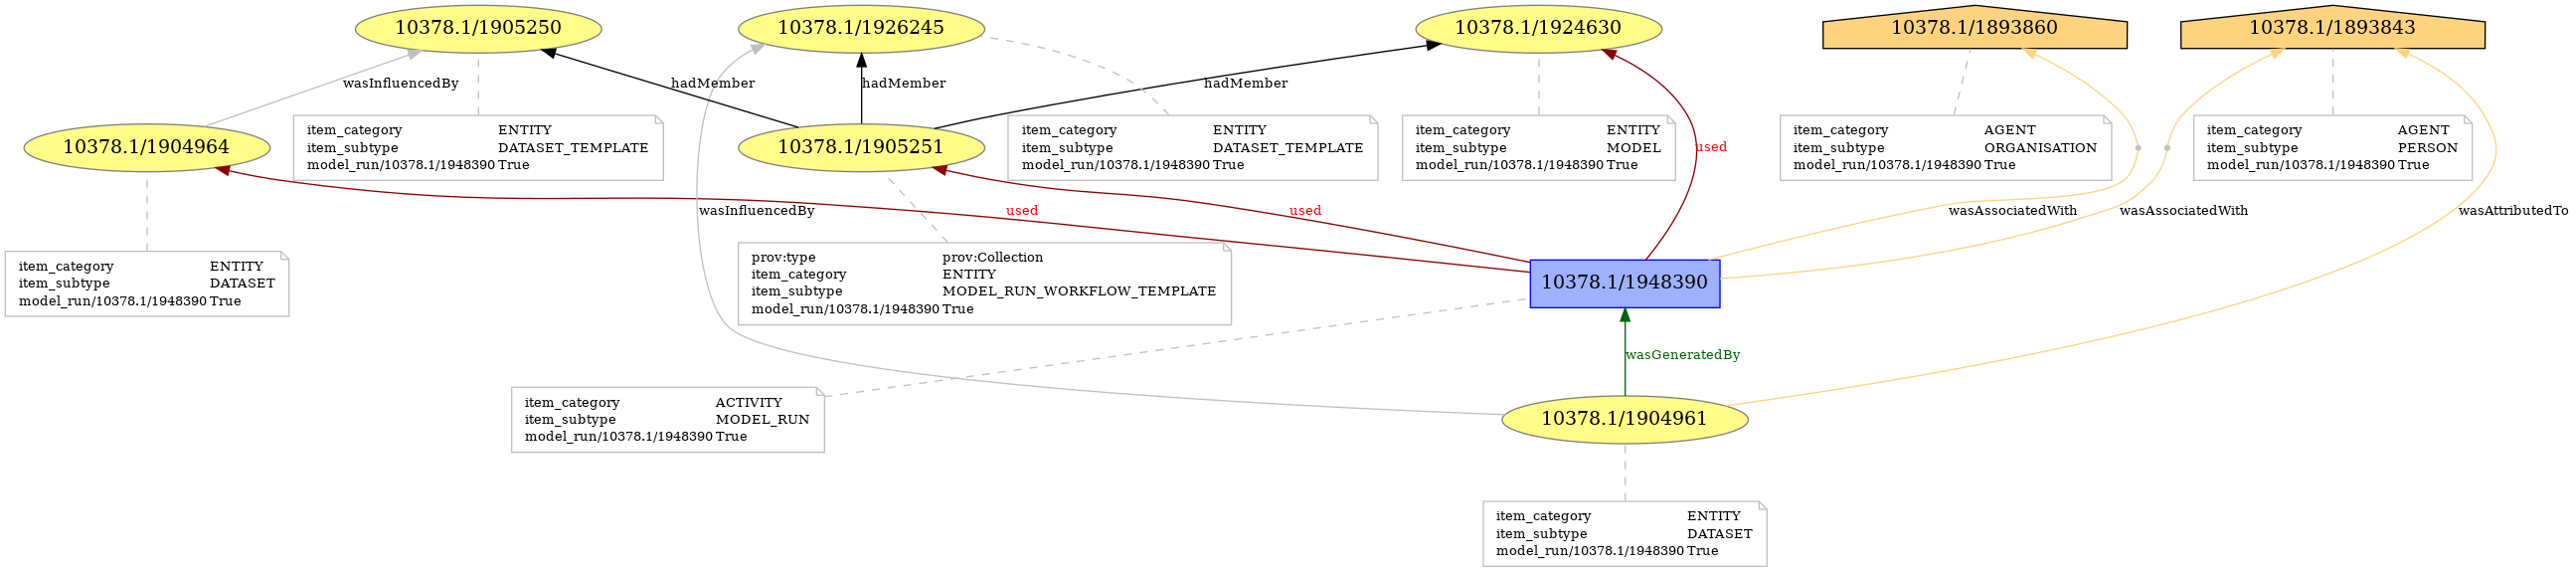

In [15]:
import prov.model as pm
from prov.dot import prov_to_dot
from IPython.display import Image

# pull out json serialisation from prov api
prov_serialisation = method_two_record_info["prov_json"]

# parse into prov document
document = pm.ProvDocument.deserialize(source=None, content=prov_serialisation)

# render into file
dot = prov_to_dot(document)
name = "resources/prov_graph"

dot.write_png(name + '.png')
Image(name + '.png')

#### Registering a dataset during model run registration

Now let's perform method 1) i.e. register a dataset during automated model run provenance registration.

Datasets require the following fields.


```json
{
  "associations": {
    "organisation_id": "string"
  },
  "dataset_info": {
    "name": "string",
    "description": "string",
    "access_info": {
      "reposited": true,
      "uri": "string",
      "description": "string"
    },
    "publisher_id": "string",
    "created_date": "2023-06-06",
    "published_date": "2023-06-06",
    "license": "string",
    "preferred_citation": "string",
    "keywords": [
      "string"
    ],
    "version": "string"
  },
  "approvals": {
    "ethics_registration": {
      "relevant": false,
      "obtained": false
    },
    "ethics_access": {
      "relevant": false,
      "obtained": false
    },
    "indigenous_knowledge": {
      "relevant": false,
      "obtained": false
    },
    "export_controls": {
      "relevant": false,
      "obtained": false
    }
  }
}
```

In [16]:
from ProvenaInterfaces.RegistryAPI import *
from ProvenaInterfaces.DataStoreAPI import CollectionFormat

default_license = "https://gbrrestoration.github.io/rrap-mds-knowledge-hub/information-system/licenses.html#copyright-all-rights-reserved"
output_path = "s3://example-bucket/test-data.csv"

dataset_payload = CollectionFormat(
        associations= CollectionFormatAssociations(
            organisation_id=config.associations.organisation,
            data_custodian_id=config.associations.person,
            point_of_contact=None
        ),
        approvals=CollectionFormatApprovals(
            ethics_registration=DatasetEthicsRegistrationCheck(),
            ethics_access=DatasetEthicsAccessCheck(),
            indigenous_knowledge=IndigenousKnowledgeCheck(),
            export_controls=ExportControls()
        ), 
        dataset_info=CollectionFormatDatasetInfo(
            name="Notebook Example workflow",
            description = "Example workflow output (Standard Provena),Generated in automated provenance workflow registration. Externally reposited", 
            access_info=AccessInfo(reposited=False, uri = output_path, description="The file is stored in the Example storage at the specified path"),
            publisher_id=config.associations.organisation,
            created_date= CreatedDate(relevant = False, value = None),
            published_date= PublishedDate(relevant = False, value = None),
            license=default_license,
            purpose = None, 
            rights_holder=None,
            usage_limitations=None,
            temporal_info=None,
            formats=None,
            keywords=[ "JYI","Example"],
            user_metadata=None,
            version=None
        )
        
)

register_dataset = await client.datastore.mint_dataset(dataset_mint_info=dataset_payload)

output_dataset_id = register_dataset.handle

print(f"Minted new dataset successfully with handle {output_dataset_id}.")

Minted new dataset successfully with handle 10378.1/1948393.


Now we have dynamically generated an output dataset. 

We could choose to actually upload the files to this dataset using the dynamic s3 credential generation. 

However, in the NBIC workflows we just want to refer to the existing storage location - so we use the externally reposited option as above to specify this path. 

Now we can use the same model run payload, replacing the output dataset with the dynamically generated output above.

In [17]:
model_run_payload.outputs[0].dataset_id = output_dataset_id

## Registering the model run 
payload = model_run_payload
print("Registering model run")
model_run_register_response = await client.prov_api.register_model_run(model_run_payload=payload)

Registering model run


In [18]:


# Check the job to see if it's complete. We will do this by polling the job_api
job_result = await client.job_api.await_successful_job_completion(session_id=model_run_register_result.session_id)

while job_result.status != JobStatus.SUCCEEDED: # Keep polling on this cell till this turns to "SUCCEEDED"
    
    job_result = await client.job_api.await_successful_job_completion(session_id=model_run_register_result.session_id)
    pprint(job_result.result)
    pprint(job_result.job_type)


print()
print("Current job status:", job_result.status) 

Starting wait_for_entry_in_queue polling stage.
Polling Job API. Wait time: 0sec out of 20sec.
Running wait_for_entry_in_queue callback. Session ID: 4a2e188b-3803-404c-a249-b2a5db01e103.
200OK response for user fetch of 4a2e188b-3803-404c-a249-b2a5db01e103.
Finished wait_for_entry_in_queue polling stage.

Current job status: JobStatus.SUCCEEDED


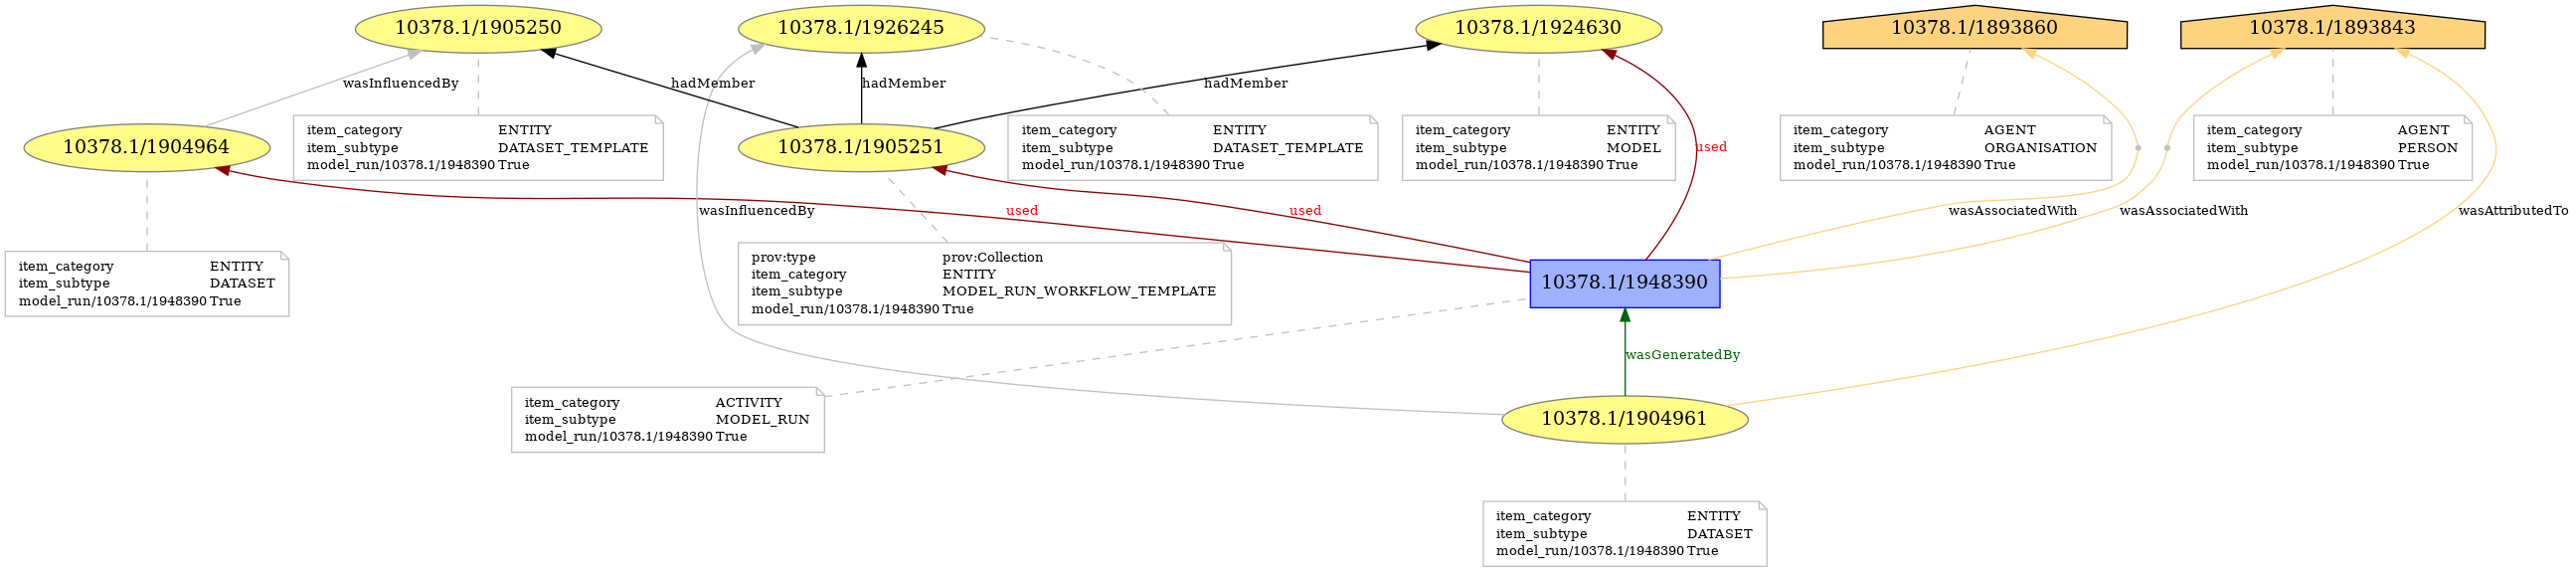

In [19]:
method_one_record_info = job_result.result["record"]

# pull out json serialisation from prov api
prov_serialisation = method_one_record_info["prov_json"]

# parse into prov document
document = pm.ProvDocument.deserialize(source=None, content=prov_serialisation)

# render into file
dot = prov_to_dot(document)
name = "resources/prov_graph"

dot.write_png(name + '.png')
Image(name + '.png')

## Demonstrating download and upload

If, unlike in the above demonstration, we wanted to upload and download files, it is easy to use the Provena APIs to automate this process. 

The high level steps are:

1. Identify or register the dataset
2. Use the API to generate credentials to r/w to the dataset
3. Use these credentials in your S3 client of choice to r/w data

We will demonstrate these steps below

In [20]:
# First, let's register a dataset

default_license = "https://gbrrestoration.github.io/rrap-mds-knowledge-hub/information-system/licenses.html#copyright-all-rights-reserved"
dataset_payload = CollectionFormat(
    associations=CollectionFormatAssociations(
        organisation_id=config.associations.organisation,
        data_custodian_id=None,
        point_of_contact=None
    ),
    approvals=CollectionFormatApprovals(
        ethics_registration=DatasetEthicsRegistrationCheck(
            relevant=False,
            obtained=False
        ),
        ethics_access=DatasetEthicsAccessCheck(
            relevant=False,
            obtained=False
        ),
        indigenous_knowledge=IndigenousKnowledgeCheck(
            relevant=False,
            obtained=False
        ),
        export_controls=ExportControls(
            relevant=False,
            obtained=False
        )
    ),
    dataset_info=CollectionFormatDatasetInfo(
        name="Demonstration upload download dataset",
        description="This dataset is used to demonstrate automated upload and download of files.",
        access_info=AccessInfo(
            reposited=True,
            uri=None,
            description=None
        ),
        publisher_id=config.associations.organisation,
        created_date=CreatedDate(relevant = True, value = date(year=2023, month=6, day=6)),
        published_date=PublishedDate(relevant = True, value = date(year=2023, month=6, day=6)),
        license=default_license,
        purpose=None,
        rights_holder=None,
        usage_limitations=None,
        temporal_info=None,
        formats=None,
        keywords=["JYI", "Example"],
        user_metadata=None,
        version=None
    )
)

# send off request
print("Registering dataset")
dataset_mint_response = await client.datastore.mint_dataset(dataset_mint_info=dataset_payload)

dataset_id = dataset_mint_response.handle

print(f"Minted new dataset successfully with handle {dataset_id}.")

Registering dataset
Minted new dataset successfully with handle 10378.1/1948395.


In [21]:

dataset_id = dataset_mint_response.handle
bucket_name = dataset_mint_response.s3_location.bucket_name
bucket_path = dataset_mint_response.s3_location.path

print(f"Name: {bucket_name}, Path: {bucket_path}")

Name: restored-dev-dev-rrap-storage-bucket-11102022-11102022, Path: datasets/10378-1-1948395/


### Now we can use the built in download and upload methods, or we can spin up our own.


In [22]:

from tempfile import TemporaryDirectory

with TemporaryDirectory() as upload_dir: 
    # Assume we have these files in our local system initially
    local_files = ['document.txt', 'photo.jpg', 'data.csv']

    # Create the files locally to simulate existing files
    for file_name in local_files:
        with open(os.path.join(upload_dir, file_name), 'w') as file:
            file.write(f"This is the content of {file_name}.")
    
    # Upload all files created in temp directory.
    await client.datastore.io.upload_all_files(source_directory=upload_dir, dataset_id=dataset_id)        
 
    # Download and check into temp dir
    with TemporaryDirectory() as download_dir: 
        print("Downloading files...")
        await client.datastore.io.download_all_files(destination_directory=download_dir, dataset_id=dataset_id)
        print()
        
        print("Resulting files...")
        files = os.listdir(download_dir)
        for f in files:
            print(f)


Resulting files...
photo.jpg
metadata.json
document.txt
data.csv


In [23]:
from ProvenaInterfaces.DataStoreAPI import CredentialsRequest

# Or we can use AWS S3 SDK directly, for example
import boto3 

# Generate Write Credentials through the client library
credential_request = CredentialsRequest(dataset_id=dataset_id, console_session_required=False)
creds = await client.datastore.generate_write_access_credentials(credentials=credential_request)

# This will mess up constructor - remove for now
filtered_creds = {k : v for k,v in creds.credentials if k != "expiry"}

# create a session
s3 = boto3.client('s3', **filtered_creds)

# now lets demonstrate uploading/downloading directly
with TemporaryDirectory() as upload_dir: 
    # Assume we have these files in our local system initially
    local_files = ['document2.txt', 'photo2.jpg', 'data2.csv']

    # Create the files locally to simulate existing files
    for file_name in local_files:
        with open(os.path.join(upload_dir, file_name), 'w') as file:
            file.write(f"This is the content of {file_name}.")

    # Upload all files in dir
    print("Uploading files using S3 SDK...")
    for f in local_files:
        s3.upload_file(os.path.join(upload_dir, f),bucket_name,bucket_path +  f)
        
    print()
    
    # Download and check into temp dir
    with TemporaryDirectory() as download_dir: 
        print("Downloading files...")
        await client.datastore.io.download_all_files(destination_directory=download_dir, dataset_id=dataset_id)
        print()
        
        print("Resulting files...")
        files = os.listdir(download_dir)
        for f in files:
            print(f)

Uploading files using S3 SDK...


Resulting files...
photo.jpg
metadata.json
document.txt
data2.csv
data.csv
photo2.jpg
document2.txt
